<center> 

# **CASE STUDY: TTC STREETCAR DELAY - A DATA SCIENCE APPROACH**

***TABLE OF CONTENT:***

*I - DATA COLLECTION & ELT* (by Jay Menarco)

*II - DATA PRE-PROCESSING / FEATURE ENGINEERING* (by Ly Nguyen)

*III - ANALYSIS* (by Ly Nguyen) 

*- Hyperparameter Tuning*

*- Random Forest Classification* 

*- Model Evaluation*
    

*IV - INSIGHTS & DATA VISUALIZATION* (by XiaoXiao, Shruti, Namreen)
 
*V - CONCLUSION* (by XiaoXiao, Shruti, Namreen)

</center>

<center>

# **I - DATA COLLECTION / ELT** 
By: Jay Menarco.

</center>

**PRELIMINARY STEP: GITHUB REPOSITORY SETUP:**

- Github repository: jays-codes/team24
- Description: Main branch, developent branch, and release branch. 
- Each team member forked the repository (all branches), and worked (push/pull changes) on the development branch.

**DATA COLLECTION / ETL**

- Performed ETL (Extract, Load, Transform): 
    - Extracted the following dataset, saved to SQLite database and Github repo: 
        - TTC Streetcar Delay, FY2023 and YTD-09-2024 (https://open.toronto.ca/dataset/ttc-streetcar-delay-data/): directly extracted to Github. 
    
    - Created the following datasets, saved to SQLite database and/or Python dataframes and Github repository:  
        - Ontario Public Holiday, 2023 and 2024 (https://excelnotes.com/holidays-ontario-2023/ and https://excelnotes.com/holidays-ontario-2024): no file available, only information online. We manually created the datasets in .csv and saved to Github. 
        - Line route (https://www.ttc.ca/routes-and-schedules/listroutes/streetcar): no file available, only information online. We manually created the datasets in .csv and saved to Github.  
    
    - Loaded: 
        - Loaded the data to SQLite database 
        - From SQLite database, loaded to Python Panda dataframe. 
   
    - Transformed: 
        - Joined datasets to prepare for analysis: 
        - Performed some feature-engineering to prepare for analysis 
   


# *DATA COLLECTION & ELT*

In [1]:
#Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd


**LOADING**

In [2]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [3]:

# Check if __file__ is defined
if '__file__' in globals():
    # Get the directory two levels up from the current script
    base_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
else:
    # Fallback for environments where __file__ is not defined
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    
    # Construct the relative path to the database
db_name = os.path.join(base_dir, 'data', 'streetcardelaydb.db')
table_name = 'Streetcar_Delay_Data'  # Replace with your table name

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data from SQLite database
df = load_from_db(db_name, table_name)




**TRANSFORMING**

In [4]:
# Convert Incident_Date to datetime
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get isHoliday, isWeekend, and isEndOfMth columns
date_table_name = 'Date'  # Replace with your date table name
date_df = load_from_db(db_name, date_table_name)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'isHoliday', 'isWeekend', 'isEndOfMth']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)


# Load Line table to get lineType
line_table_name = 'Line'  # Replace with your line table name
line_df = load_from_db(db_name, line_table_name)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineType']], left_on='line', right_on='lineId', how='left')

#for lineType that has not been set, set it to 4
df['lineType'] = df['lineType'].fillna(4)

# Load Delay table to get delayType
delay_table_name = 'Delay'  # Replace with your delay table name
delay_df = load_from_db(db_name, delay_table_name)

# Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Display the DataFrame
df.head()

,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,isHoliday,isWeekend,isEndOfMth,lineId,lineType,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,1,1,0,505,2.0,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,1,1,0,504,2.0,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,1,1,0,504,2.0,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,1,1,0,510,2.0,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,1,1,0,506,2.0,2


<center>

# **DATA PRE-PROCESSING / FEATURE ENGINEERING** 

By: Ly Nguyen 

</center>

**- Exploratory data analysis**

- Assess min, max, quantiles, standard deviations of features
- Assess class imbalance
- Assess outliers 

**- Data Pre-processing:**

- Handle any NULL values, NA values, and zeros. 

- Select the response variable and the predictors:
    - Predictors:
        - Day (7 categories: Monday -> Sunday)

        - Holiday (2 categories: Yes / No)

        - Time (4 categories: peak morning, peak afternoon, peak evening, others)

        - Line (4 categories: regular, special, night, others (ie. bus substitute))

        - Location (~3,000 unique locations)

        - Bound (4 categories: N, S, W, E)

        - Vehicle (~2,000 unique vehicles)

        - Incident category (13 categories)


    - Response variable:
        - Delay time (3 categories: short delay, expected delay, long delay) 

- Use Statistical Inference with visualization tools: 

    - Handle significant outliers 
    
- Feature engineering:
    - Create new 'feature_id' columns - to be used for machine learning models. 
    
    - Note: For this project, we explore using Random Forest Classifier - which can handle 'text string' values well and therefore doesn't need to be converted to numerical values datatype. However, there is a sustainable benefit in converting them to numerical datatype as they can be used for other machine learning models - if we shall want to do so in the future.
    

# *EXPLORATORY ANALYSIS*


In [5]:
# Display exploratory statistics
df.describe()

,incident_date,min_delay,min_gap,isHoliday,isWeekend,isEndOfMth,lineType,delayType
count,21742,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000
mean,2023-11-17 14:32:47.730659584,18.185494,27.249885,0.027504,0.282771,0.032978,2.017708,2.133014
min,2023-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,2023-11-24 00:00:00,10.000000,20.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,2024-04-15 00:00:00,15.000000,24.000000,0.000000,1.000000,0.000000,2.000000,2.000000
max,2024-09-30 00:00:00,960.000000,968.000000,1.000000,1.000000,1.000000,4.000000,3.000000
std,NaN,37.272247,39.340414,0.163552,0.450356,0.178582,0.261982,0.561122


**Observation:**

- Count of observations: > 20,000 observations in our dataset - which is sufficient. 
- Delay time: 
    - The statistical distribution appears to be skewed to the right.
    - The majority of delay is **within** 15 minutes value (960) and large standard deviation (37) - in comparison to mean (18) and 75% quantile (15). 
- We choose Delay time ('min_delay') as the response variable as it is a more meaningful variable to interpret than Gap time ('min_gap').
- The rest of our features to be chosen looks okay.


In [6]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  isHoliday      21742 non-null  int64         
 11  isWeekend      21742 non-null  int64         
 12  isEndOfMth     21742 non-null  int64         
 13  lineId         21574 non-null  object        
 14  lineType       21742 non-null  float64       
 15  delayType      2174

**Observation:**
    
- We have >20,000 observations, and <2,000 NULL values. So, we can remove NULL values without significant impact.

In [7]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
isHoliday           2
isWeekend           2
isEndOfMth          2
lineId             16
lineType            4
delayType           3
dtype: int64

**Observation:**
- The 'bound' variable shows 8 unique values - which is wrong. It should be 4 ('N' North, 'S' South, 'W' West, 'E' East). 
- The rest looks okay.

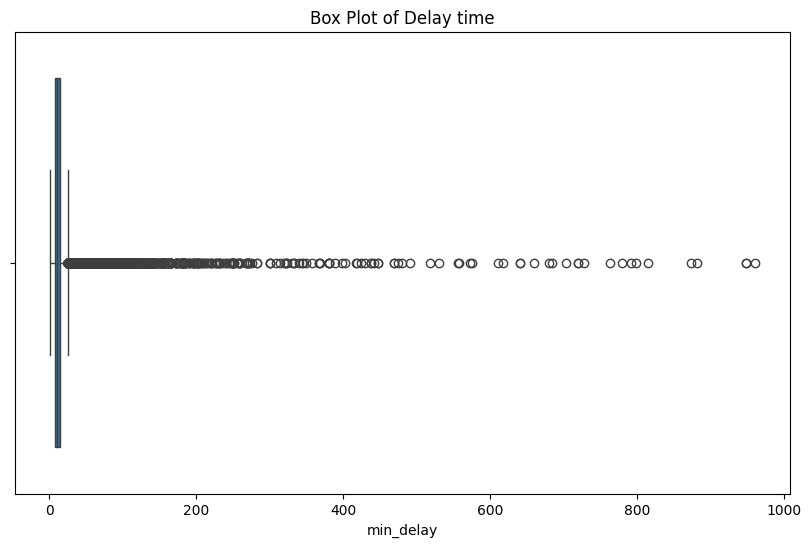

In [8]:
# Check for class imbalance with data visualization tools.

# Import libraries for data visualization to graph whisker plot, influence plot, and histogram. 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

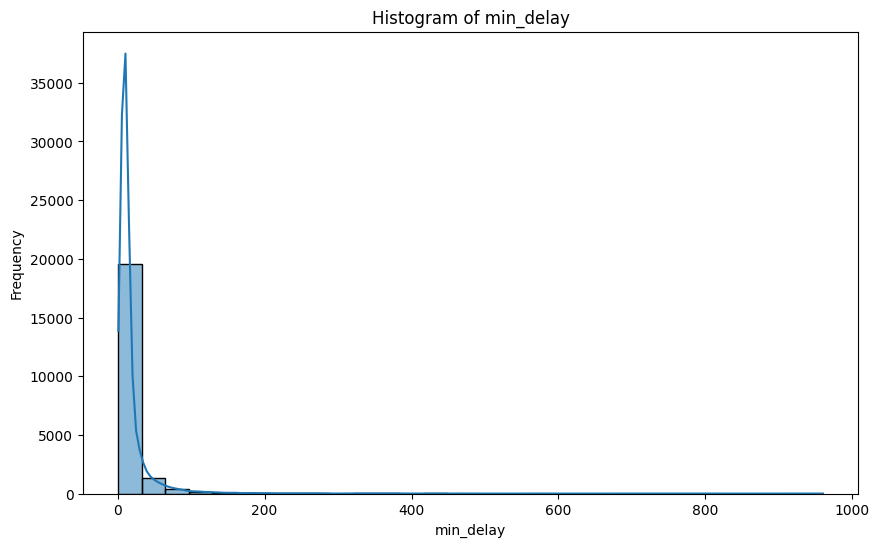

In [9]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

**Observation:**

- Most of the Delay time observations fall within 15 minutes (the boxplot)
- A lot of outliers outside of 15 minutes, extending as far as 900s minutes. 
- Data Distribution is skewed to the right. 
- We have several options to approach this case study: 
    - Option 1: Focus the analysis on the most frequently encountered delays - ie. within 15 minutes delay. 
    - Option 2: Focus the analysis on the most disruptive and significant delays - ie. above 600s minutes. 
    - Option 3: Include all data points to have a general view, and accept the possibility of a less accurate prediction. 

**Approach:**

- For this project scope, we choose **Option 3: to have a general view, accepting the possibility of a less accurate prediction**. 

- We try to minimize inaccuracies as much as possible for Option 3, by using a Classifier, defining classes of 'frequent delays' and 'disruptive/significant delays', and Random Forest Classifier as it is generally robust with outliers. 
    - Class 1 - Short delay time: <= 5 minutes delay 
    - Class 2 - Expected delay time: between 6 - 15 minutes delay 
    - Class 3 - Long delay time: over 15 minutes delay. 

- (Remark: Option 1 and Option 2 are *out of scope* but can be studied separately in the future.)


# *DATA PRE-PROCESSING / FEATURE ENGINEERING*

In [10]:
# Convert incident_time to datetime
df['incident_time'] = pd.to_datetime(df['incident_time'], format='%H:%M').dt.time

# Define function to categorize time
def categorize_time(time):
    if time >= pd.to_datetime('06:30').time() and time <= pd.to_datetime('09:30').time():
        return 1
    elif time >= pd.to_datetime('10:00').time() and time <= pd.to_datetime('14:00').time():
        return 2
    elif time >= pd.to_datetime('16:30').time() and time <= pd.to_datetime('19:00').time():
        return 3
    else:
        return 4

# Apply function to create new column "timeType"
df['timeType'] = df['incident_time'].apply(categorize_time)


# Clean and factorize columns: location, bound, incident, vehicle, day_of_week
# Define a helper function
def clean_and_factorize(df, column_name, valid_values=None):
    # Remove leading and trailing spaces
    df[column_name] = df[column_name].str.strip()
    
    # Drop null values
    df = df.dropna(subset=[column_name])
    
    # If valid values are provided, filter the dataframe
    if valid_values:
        df = df[df[column_name].isin(valid_values)]
    
    # Assign unique numeric values
    df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
    
    return df

# Apply the function to each column
df = clean_and_factorize(df, 'location')
df = clean_and_factorize(df, 'incident')
df = clean_and_factorize(df, 'vehicle')
df = clean_and_factorize(df, 'day_of_week')
df = clean_and_factorize(df, 'line')
df = clean_and_factorize(df, 'bound', valid_values=['N', 'S', 'W', 'E'])


# Display the DataFrame
df.head()


C:\Users\DELL\AppData\Local\Temp\ipykernel_33736\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_33736\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1


,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,...,lineId,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,2023-01-01,505,02:40:00,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,...,505,2.0,2,4,1,1,1,1,1,1
1,2023-01-01,504,02:52:00,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,...,504,2.0,2,4,2,2,2,1,2,1
2,2023-01-01,504,02:59:00,Sunday,KING AND BATHURST,Held By,25,35,E,4560,...,504,2.0,3,4,2,1,3,1,2,2
3,2023-01-01,510,05:38:00,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,...,510,2.0,2,4,3,3,4,1,3,3
5,2023-01-01,501,08:52:00,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,...,501,2.0,2,1,5,2,6,1,5,1


In [11]:
# Verify that there are 4 'bound' unique values: 
df.nunique()

incident_date      639
line                42
incident_time     1438
day_of_week          7
location          2936
incident            14
min_delay          246
min_gap            268
bound                4
vehicle           1537
isHoliday            2
isWeekend            2
isEndOfMth           2
lineId              16
lineType             4
delayType            3
timeType             4
location_id       2936
incident_id         14
vehicle_id        1537
day_of_week_id       7
line_id             42
bound_id             4
dtype: int64

In [12]:
# Verify that the NULL objects have been dropped. 
null_counts = df.isnull().sum()
print(null_counts)

incident_date       0
line                0
incident_time       0
day_of_week         0
location            0
incident            0
min_delay           0
min_gap             0
bound               0
vehicle             0
isHoliday           0
isWeekend           0
isEndOfMth          0
lineId            104
lineType            0
delayType           0
timeType            0
location_id         0
incident_id         0
vehicle_id          0
day_of_week_id      0
line_id             0
bound_id            0
dtype: int64


**Comment:** 
- The "lineId" column was created as primary key to join tables only. We can drop this, along with other non-beneficial predictors - see codes below.

In [13]:
# Drop null values in 'lineId'
df = df.dropna(subset=['lineId'])

# Drop the following columns: incident_date, incident_time, min_gap, isEndOfMth, lineID. min_delay
df_cleaned = df.drop(['incident_date','incident_time', 'min_gap', 'isEndOfMth', 'lineId'], axis=1)

# Verify the columns are dropped
df_cleaned.head()

,line,day_of_week,location,incident,min_delay,bound,vehicle,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,505,Sunday,BROADVIEW AND GERRARD,Held By,15,W,4460,1,1,2.0,2,4,1,1,1,1,1,1
1,504,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,W,4427,1,1,2.0,2,4,2,2,2,1,2,1
2,504,Sunday,KING AND BATHURST,Held By,25,E,4560,1,1,2.0,3,4,2,1,3,1,2,2
3,510,Sunday,SPADINA AND DUNDAS,Security,15,S,4449,1,1,2.0,2,4,3,3,4,1,3,3
5,501,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,W,8015,1,1,2.0,2,1,5,2,6,1,5,1


**Note:**
- The unique ids columns (ie. location_id, vehicle_id, etc.) will be used in the predicitve models. 
- We are keeping names of predictors (e.g., line, day_of_week, etc) to re-map them to their unique ids later during the data visualization.

In [14]:
# Reviewing the data types and counts to make sure everything looks okay.
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18979 entries, 0 to 21741
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   line            18979 non-null  object 
 1   day_of_week     18979 non-null  object 
 2   location        18979 non-null  object 
 3   incident        18979 non-null  object 
 4   min_delay       18979 non-null  int64  
 5   bound           18979 non-null  object 
 6   vehicle         18979 non-null  object 
 7   isHoliday       18979 non-null  int64  
 8   isWeekend       18979 non-null  int64  
 9   lineType        18979 non-null  float64
 10  delayType       18979 non-null  int64  
 11  timeType        18979 non-null  int64  
 12  location_id     18979 non-null  int64  
 13  incident_id     18979 non-null  int64  
 14  vehicle_id      18979 non-null  int64  
 15  day_of_week_id  18979 non-null  int64  
 16  line_id         18979 non-null  int64  
 17  bound_id        18979 non-null  int6

In [15]:
# Reviewing the dataframe to make sure everything looks okay. 
df_cleaned.describe()

,min_delay,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
count,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000
mean,17.633542,0.027030,0.282259,2.002371,2.122557,3.136625,565.652932,5.542494,336.286475,4.083619,4.830497,1.998314
std,35.667862,0.162175,0.450111,0.192998,0.558937,1.091569,724.594081,2.967546,354.037560,1.990338,4.377895,1.003785
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,90.000000,3.000000,98.000000,2.000000,2.000000,1.000000
50%,10.000000,0.000000,0.000000,2.000000,2.000000,4.000000,247.000000,5.000000,209.000000,4.000000,4.000000,2.000000
75%,14.000000,0.000000,1.000000,2.000000,2.000000,4.000000,703.000000,8.000000,402.000000,6.000000,5.000000,2.500000
max,960.000000,1.000000,1.000000,3.000000,3.000000,4.000000,3197.000000,14.000000,1578.000000,7.000000,41.000000,4.000000


# *ASSESSING FOR ANY CLASS IMBALANCE*

In [16]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12765
3     4270
1     1944
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_33736\2728593396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')


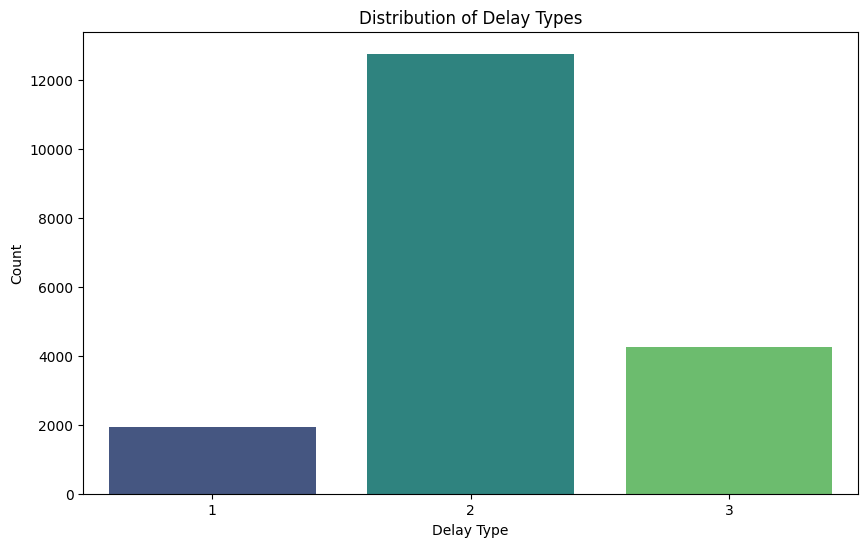

In [17]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


**Observation:**
- delayType 1 (Short Delay Time - within 5 minutes): 1,953 observations. 
- delayType 2 (Expected Delay Time - between 6 and 15 minutes): 12,829 observations. **This class significantly dominates the dataset.**
- delayType 3 (Long Delay Time - over 15 minutes): 4,301 observations. 

<center>

# **ANALYSIS**
by: Ly Nguyen

<center>

# *PREDICTIVE METHOD: RANDOM FOREST CLASSIFIER* 

**SETTING TRAINING & TEST SETS** 

In [18]:
# Import panda and ML Random Forest Classifier libraries 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Convert the delayType to numerical values
df_cleaned['delayType_id'] = pd.factorize(df_cleaned['delayType'])[0]

# Split data into features (X) and target (y)
X = df_cleaned[['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
                'isHoliday', 'isWeekend', 'lineType', 'timeType']]
y = df_cleaned['delayType_id']

# Set random seed for reproducibility
random_seed = 42

# Split the data into training set (80%) and test set (20%) where the training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)




# *HYPERPARAMETER TUNING - FINDING OPTIMAL ML PARAMETERS*

In [19]:
# Import the GridSearch Cross-Validator library
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # testing different numbers of trees in the forest: 50 trees, 100 trees, 200 trees. 
    'max_depth': [None, 10, 20, 30], # preventing overfitting by limiting how deep the trees can grow: max 10 levels, 20 levels, 30 levels. 
    'min_samples_split': [2, 5, 10], # further reducing overfitting, by controlling the growth of the trees, by specifying the minimum number of samples required to split an internal node: allowing split even if only 2 samples are present, 5 samples are present, 10 samples are present. 
    'min_samples_leaf': [1, 2, 4] # further reducing overfitting, by controlling the size of the tree, by determining the minimum number of samples required to be at a leaf node: allowing leaves to contain 1 sample, 2 samples, 4 samples. 
}


In [20]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
                    estimator=clf, # select "clf" (Random Forest Classifier - defined above) as the estimator. 
                    param_grid=param_grid, # defines the hyperparameters (defined in the cell above) and their possible values to be searched over. 
                    cv=5, # specifies the number of cross-validation folds to be used: 5. Ie. Split the data into 5 subsets, each taking turn as training set and validation set. The process is repeated 5 tiems. 
                    scoring='accuracy', # specifies the metric "accuracy" as the scoring metric to evaluate the model's performance. Accuracy is the ratio of correctly predicted instances to the total instances.
                    n_jobs=-1) # tells GridSearchCV to use all available CPU cores for computation, speeding up the computation process.

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [21]:
# Best parameters from GridSearchCV
best_params = {'n_estimators': 200, # Number of trees in the forest
               'max_depth': 10, # Maximum depth of the tree
               'min_samples_leaf': 4, # Minimum number of samples required to be at a leaf node
               'min_samples_split': 2, # Minimum number of samples required to split an internal node
                } 

# Initialize and fit the Random Forest Classifier with best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

# *RANDOM FOREST CLASSIFIER - WITH THE OPTIMAL PARAMETERS*

In [22]:
# Import the Random Forest Classifier library
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest Classifier with best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

clf.fit(X_train, y_train)

# Predicting the delay types
y_pred = clf.predict(X_test)

# Get feature importances
feature_importances = best_clf.feature_importances_
features = ['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
    'isHoliday', 'isWeekend', 'lineType', 'timeType'
    ]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
1     incident_id    0.399185
2      vehicle_id    0.200734
4         line_id    0.137538
0     location_id    0.096622
3  day_of_week_id    0.039866
8        lineType    0.039701
9        timeType    0.034250
5        bound_id    0.033343
7       isWeekend    0.016364
6       isHoliday    0.002397


# *MODEL PERFORMANCE EVALUATION*

**Note:** The order of class labels (0, 1, 2) in sklearn’s classification report aligns with the order they are sorted in the dataframe's value_counts() output. So, let's do the value_counts() to see the mapping. 

In [23]:
# Double-check the class order that sklearn outputs, as it aligns with the order the are sorted in the dataframe's value_counts() output.
print(df_cleaned['delayType'].value_counts())

delayType
2    12765
3     4270
1     1944
Name: count, dtype: int64


**Observation:** 

The order is: 

- **Class 0** maps to **delayType 2 (Expected Delay Time: 6-15 minutes)**
- **Class 1** maps to **delayType 3 (Long Delay Time: >15 minutes)**
- **Class 2** maps to **delayType 1 (Short Delay Time: <= 5 minutes)**

# 1) Accuracy, Precision, Recall and F1 Score

In [24]:
# Import the Classification Evaluator library
from sklearn.metrics import classification_report

# Run the evaluation on the model's performance with custom labels
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      2559
           1       0.60      0.39      0.47       863
           2       0.66      0.26      0.38       374

    accuracy                           0.72      3796
   macro avg       0.67      0.52      0.56      3796
weighted avg       0.71      0.72      0.70      3796



**INTERPRETATION:**

- **Accuracy:** **72%** of the predictions made by the model are correct.

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    - **Class 0** (delayType 2 - Expected Delay Time: 6-15 minutes): This class **performs well** with high scores across precision, recall, and f1 (75%, 91%, 82%). 
       
    - **Class 1** (delayType 3 - Long Delay Time: over 15 minutes ): This class **performs poorly** on the recall score (39%), with many actual Class 1 instances are not being predicted as Class 1. 

    - **Class 2** (delayType 1 - Short Delay Time: <=5 minutes): This class **performs poorly** on the recall score (26%), with many actual Class 2 instances are not being predicted as Class 2. 



# 2) EVALUATION - COMMENT:

Our predictive model gives acceptable performance on the accuracy score (73%) with 73% of the predictions made by this model are correct. 

The model also performs well for Class 0 (delayType 2 - Expected Delay Time: 6-15 minutes) across precision (76%), recall (90%) and F1 scores (82%). This class also significantly dominates the dataset. 

With these acceptable scores, we can rely on this model to achieve our business objective which is to find the most likely predictors of delay times, especially for Class 0 which is the most frequently encountered delay type (delay between 6-15 minutes). 

For future studies, we recommend further analysis into other delay types for a more accurate understanding of most likely predictors, and therefore for pre-emptive actions. 



    